# Detecting intelligent text entry (keystroke-level analysis)

In [7]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
import pandas_profiling
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('autumn')
from pandas.api.types import is_numeric_dtype


def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)

# Supress scientific notation 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load and profile test-section-level data

In [8]:
# Load data of valid participants 
TS_QUERY = "SELECT * FROM FIRST_15_TEST_SECTIONS" 
test_sections = pd.read_sql_query(TS_QUERY, engine)
test_sections.fillna(0, inplace=True)


In [9]:
pfr = pandas_profiling.ProfileReport(test_sections)
pfr.to_file("../profiles/valid_test_sections.html")
print('Done.')

Done.


# Load and profile LOD_DATA sample

In [12]:
LD_SAMP_QUERY = """
select * from LOG_DATA 
where test_section_id in (
select TEST_SECTION_ID 
from FIRST_15_TEST_SECTIONS 
)
limit 1000000
"""
ld_sample = pd.read_sql_query(LD_SAMP_QUERY, engine)
ld_sample.fillna(0, inplace=True)

In [13]:
ld_sample.tail().T

999995  \
LOG_DATA_ID                                                   3328703   
TEST_SECTION_ID                                                 25252   
TYPE                                                            input   
KEY                                                         undefined   
CODE                                                        undefined   
DATA                                                            Chase   
INPUT                                                           Chase   
PRESSED                                                        13,229   
TIMESTAMP                                               1537640423351   
DEVICE_ORIENTATION  {"alpha":"122.29","beta":"28.29","gamma":"-3.42"}   
SCREEN_ORIENTATION                                                  0   
DATA_LDIST                                                      1.000   
DATA_LEN                                                        5.000   
DATA_PRLEN                                                      4.000   
ITE_SWYP                                                        0.000   
ITE_AUTO                                                        0.000   
ITE_PRED                                                        0.000   
ITE_NORM                                                        1.000   
INPUT_IKI                                                           0   

                                                               999996  \
LOG_DATA_ID                                                   3328704   
TEST_SECTION_ID                                                 25252   
TYPE                                                            keyup   
KEY                                                      Unidentified   
CODE                                                                    
DATA                                                        undefined   
INPUT                                                           Chase   
PRESSED                                                                 
TIMESTAMP                                               1537640423358   
DEVICE_ORIENTATION  {"alpha":"122.29","beta":"28.29","gamma":"-3.42"}   
SCREEN_ORIENTATION                                                  0   
DATA_LDIST                                                      0.000   
DATA_LEN                                                        0.000   
DATA_PRLEN                                                      0.000   
ITE_SWYP                                                        0.000   
ITE_AUTO                                                        0.000   
ITE_PRED                                                        0.000   
ITE_NORM                                                        0.000   
INPUT_IKI                                                           0   

                                                               999997  \
LOG_DATA_ID                                                   3328706   
TEST_SECTION_ID                                                 25252   
TYPE                                                          keydown   
KEY                                                      Unidentified   
CODE                                                                    
DATA                                                        undefined   
INPUT                                                           Chase   
PRESSED                                                        13,229   
TIMESTAMP                                               1537640423522   
DEVICE_ORIENTATION  {"alpha":"122.57","beta":"27.65","gamma":"-4.25"}   
SCREEN_ORIENTATION                                                  0   
DATA_LDIST                                                      0.000   
DATA_LEN                                                        0.000   
DATA_PRLEN                                                      0.000   
ITE_SWYP                                      

In [11]:
pfr = pandas_profiling.ProfileReport(ld_sample)
pfr.to_file("../profiles/keystrokes_sample.html")
print('Done.')

Done.


## 3. Approach based on number of keystroke events made to produce a string

In [ ]:
# 1. Prediction: 
# DATA (Sometimes empty) - grows by characters AND by chunks (chunks are either part fo word or the whole word). 
# INPUT - grows by DATA
# Number of records in LOG_DATA is somewhat between case 2 and case 3 (Nw+Ns < X < Nc+Ns) (!)

In [ ]:
# 2. Autocorrection:
# DATA (Sometimes empty) - grows mostly by character
# INPUT - grows by DATA
# Number of records in LOG_DATA is close to the number of characters all words (Nc) + number of spaces (Ns). (!)

In [ ]:
# 3. Swype: 
# DATA (Sometimes empty) - either whole-words or by spaces. 
# INPUT - grows by DATA
# Number of records in LOG_DATA is close to the number of words (Nw) + number of spaces (Ns). (!)

In [ ]:
# For each test section
# count number of records in LOG_DATA=input: TS_NUM_LDINPUTS 
# count number of words and spaces in USER_INPUT: TS_NUM_WORDS, TS_NUM_SPACES
# compare using heuristics above

In [ ]:
# count number of records in LOG_DATA=input: TS_NUM_LDINPUTS 
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_LDINPUTS DOUBLE; 

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_LDINPUTS = (                  
    SELECT COUNT(ld.LOG_DATA_ID)
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
    and ld.TYPE = 'input'
)

"""

In [1]:
# count number of words and spaces in USER_INPUT: TS_NUM_WORDS, TS_NUM_SPACES
    
# Number of words
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_WORDS DOUBLE; 

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_WORDS = ( wordcount(USER_INPUT) )
"""

# Number of spaces
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_SPACES DOUBLE; 

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_SPACES = ( LENGTH(USER_INPUT) - LENGTH(replace(USER_INPUT, ' ', '')) )
"""

# Number of words + number of spaces
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_WRDSP DOUBLE;   # Number of words + number of spaces

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_WRDSP = ( TS_NUM_WORDS + TS_NUM_SPACES )
"""

# Number of characters in all words (chars - num spaces)
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_CHSP DOUBLE; 

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_CHSP = ( LENGTH(USER_INPUT) - TS_NUM_SPACES )
"""

# Number of characters + number of spaces = len of user input
"""
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_CHARS DOUBLE; 

UPDATE FIRST_15_TEST_SECTIONS ts
set TS_NUM_CHARS = ( LENGTH(USER_INPUT) )
"""


# wordcount function from: https://eikhart.com/blog/mysql-word-count-function
"""
DELIMITER $$
CREATE FUNCTION wordcount(str TEXT)
       RETURNS INT
       DETERMINISTIC
       SQL SECURITY INVOKER
       NO SQL
  BEGIN
    DECLARE wordCnt, idx, maxIdx INT DEFAULT 0;
    DECLARE currChar, prevChar BOOL DEFAULT 0;
    SET maxIdx=char_length(str);
    WHILE idx < maxIdx DO
        SET currChar=SUBSTRING(str, idx, 1) RLIKE '[[:alnum:]]';
        IF NOT prevChar AND currChar THEN
            SET wordCnt=wordCnt+1;
        END IF;
        SET prevChar=currChar;
        SET idx=idx+1;
    END WHILE;
    RETURN wordCnt;
  END
$$
DELIMITER ;
"""

# Example of selecting USER_INPUT aling with NUM_WORDS and NUM_SPACES
"""
SELECT 
    TEST_SECTION_ID, 
    USER_INPUT, 
    wordcount(USER_INPUT) as NUM_WORDS, 
    LENGTH(USER_INPUT) - LENGTH(replace(USER_INPUT, ' ', '')) as NUM_SPACES
FROM FIRST_15_TEST_SECTIONS
"""

''

## Multi-class classification of the intelligent text entry (on test section level)

#### 1) Collect data sample (HTC One)
15 sentences mainly (but not exclusively) using SWYPE <br>
15 sentences mainly (but not exclusively) using PREDICTION<br>
15 sentences mainly (but not exclusively) using AUTOCORRECTION<br>
15 sentences mainly (but not exclusively) typing without using features <br>
15 sentences mainly (but not exclusively) typing without control for feature use<br>

DATA: <br>
ITE_sample_kseniia.csv -> participant + test sections<br>
ITE_sample_ts_kseniia.csv -> test sections<br>
ITE_sample_logd_kseniia.csv -> log_data (type=input)<br>


In [ ]:
"""
select * from LOG_DATA 
where test_section_id in (
select TEST_SECTION_ID from TEST_SECTIONS where PARTICIPANT_ID in (142921, 142927, 142951, 142963, 142969)
)
"""

In [187]:
ite_sample_ts = pd.read_csv('ITE_sample_ts_kseniia.csv')
ite_sample_ts.head(1)

TEST_SECTION_ID  SENTENCE_ID  PARTICIPANT_ID  \
0           804213         1451          142921   

                            USER_INPUT  INPUT_TIME  EDIT_DISTANCE  ERROR_RATE  \
0  We only have a power of persuasion.       11016              3    8.108108   

         WPM  INPUT_LENGTH  ERROR_LEN  POTENTIAL_WPM  POTENTIAL_LENGTH  DEVICE  
0  37.037037            34         37       15.38039                14  mobile

In [189]:
ite_sample_logd = pd.read_csv('ITE_sample_logd_kseniia.csv')
ite_sample_logd.head(1)

LOG_DATA_ID  TEST_SECTION_ID     TYPE           KEY CODE       DATA INPUT  \
0    106243397           804213  keydown  Unidentified  NaN  undefined   NaN   

  PRESSED      TIMESTAMP                                DEVICE_ORIENTATION  \
0     NaN  1542017274126  {"alpha":"78.34","beta":"30.62","gamma":"-5.24"}   

   SCREEN_ORIENTATION  
0                   0

#### 2) Lable the sample
PARTICIPANT_IP = 37.219.223.87<br>
Swype: PARTICIPANT_ID = 142921<br>
Prediction: PARTICIPANT_ID = 142927 <br>
Autocorrection: PARTICIPANT_ID = 142951 <br>
No features: PARTICIPANT_ID = 142963<br>
Uncontrolled: PARTICIPANT_ID = 142969 <br>


In [190]:
ite_sample_ts['ite'] = ''
ite_sample_ts.loc[ite_sample_ts.PARTICIPANT_ID == 142921, 'ite'] = 'swype'
ite_sample_ts.loc[ite_sample_ts.PARTICIPANT_ID == 142927, 'ite'] = 'predict'
ite_sample_ts.loc[ite_sample_ts.PARTICIPANT_ID == 142951, 'ite'] = 'autocor'
ite_sample_ts.loc[ite_sample_ts.PARTICIPANT_ID == 142963, 'ite'] = 'nothing'
ite_sample_ts.loc[ite_sample_ts.PARTICIPANT_ID == 142969, 'ite'] = 'nocontr'


#### 3) Compute metrics on the sample (locally with pandas):
TS_NUM_WORDS<br>
TS_NUM_SPACES<br>
TS_NUM_WRDSP<br>
TS_NUM_CHSP<br>
TS_NUM_CHARS<br>
TS_NUM_LDINPUTS<br>

(also numlber of baskspaces might be useful)<br>
(log data might need to be fltered from space charaters?)<br>

In [193]:
# Word counts: 
ite_sample_ts['ts_num_words'] = ite_sample_ts.USER_INPUT.str.split().str.len()
ite_sample_ts['ts_num_spaces'] = ite_sample_ts.USER_INPUT.str.count(' ')
ite_sample_ts['ts_num_wrdsp'] = ite_sample_ts.ts_num_words + ite_sample_ts.ts_num_spaces
ite_sample_ts['ts_num_chsp'] = ite_sample_ts.USER_INPUT.str.len() - ite_sample_ts.ts_num_spaces
ite_sample_ts['ts_num_chars'] = ite_sample_ts.USER_INPUT.str.len() 
ite_sample_ts['ts_num_ldinputs'] = 0
ite_sample_ts['ts_num_ldkeyups'] = 0
ite_sample_ts['ts_num_ldkeydwns'] = 0
for ts in pd.unique(ite_sample_ts.TEST_SECTION_ID):
    ite_sample_ts.loc[(ite_sample_ts.TEST_SECTION_ID == ts), 'ts_num_ldinputs'] = len(ite_sample_logd[(ite_sample_logd.TEST_SECTION_ID == ts) & (ite_sample_logd.TYPE=='input')])
    ite_sample_ts.loc[(ite_sample_ts.TEST_SECTION_ID == ts), 'ts_num_ldinputs'] = len(ite_sample_logd[(ite_sample_logd.TEST_SECTION_ID == ts) & (ite_sample_logd.TYPE=='keyup')])
    ite_sample_ts.loc[(ite_sample_ts.TEST_SECTION_ID == ts), 'ts_num_ldinputs'] = len(ite_sample_logd[(ite_sample_logd.TEST_SECTION_ID == ts) & (ite_sample_logd.TYPE=='keydown')])

    
# Normalized (by length of the sentence): 
ite_sample_ts['ts_num_words_norm'] = ite_sample_ts['ts_num_words']/ite_sample_ts['ts_num_chars']
ite_sample_ts['ts_num_spaces_norm'] = ite_sample_ts['ts_num_words']/ite_sample_ts['ts_num_chars']
ite_sample_ts['ts_num_wrdsp_norm'] = ite_sample_ts['ts_num_wrdsp']/ite_sample_ts['ts_num_chars']
ite_sample_ts['ts_num_chsp_norm'] = ite_sample_ts['ts_num_chsp']/ite_sample_ts['ts_num_chars'] 
ite_sample_ts['ts_num_ldinputs_norm'] = ite_sample_ts['ts_num_ldinputs']/ite_sample_ts['ts_num_chars'] 
ite_sample_ts['ts_num_ldkeyups_norm'] = ite_sample_ts['ts_num_ldkeyups']/ite_sample_ts['ts_num_chars'] 
ite_sample_ts['ts_num_ldkeydwns_norm'] = ite_sample_ts['ts_num_ldkeydwns']/ite_sample_ts['ts_num_chars'] 

ite_sample_ts['input_time_norm'] = ite_sample_ts.INPUT_TIME / ite_sample_ts.INPUT_LENGTH

#### 4) Train classifier(s)
https://scikit-learn.org/stable/modules/multiclass.html <br>

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier <br>

In [194]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

In [201]:
# Hypotheses: 
# ts_num_words and ts_num_ldinputs are most predictive for 'swype'
# ts_num_chars and ts_num_ldinputs are most predictive for 'autoc'

hypotheses = {
    'swype': ['input_time_norm', 'ts_num_words_norm',  'ts_num_spaces_norm', 'ts_num_ldinputs_norm'],
    #'swype': ['ts_num_words',  'ts_num_ldinputs'],
    
    'predict': ['ts_num_wrdsp_norm', 'ts_num_chsp_norm', 'ts_num_ldinputs_norm'],
   # 'predict': ['ts_num_wrdsp', 'ts_num_chsp',  'ts_num_ldinputs'],
    
    'autocor': ['input_time_norm', 'ts_num_chsp_norm', 'ts_num_words_norm', 'ts_num_ldinputs_norm'],
    #'autocor': ['ts_num_chars',  'ts_num_ldinputs'],
    
    'nothing': ['input_time_norm', 'ts_num_words_norm', 'ts_num_spaces_norm', 'ts_num_wrdsp_norm', 'ts_num_chsp_norm', 'ts_num_chars', 'ts_num_ldinputs_norm'],
    'nocontr': ['input_time_norm', 'ts_num_words_norm', 'ts_num_spaces_norm', 'ts_num_wrdsp_norm', 'ts_num_chsp_norm', 'ts_num_chars', 'ts_num_ldinputs_norm']    
}

In [202]:
classifiers = [
    NearestCentroid(metric='euclidean', shrink_threshold=None), 
    #RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0),
    GaussianNB(), 
    RidgeClassifier()
]

In [203]:
features = ['input_time_norm',
            'ts_num_words_norm', 'ts_num_spaces_norm', 'ts_num_wrdsp_norm', 'ts_num_chsp_norm', 'ts_num_ldinputs_norm',
            'ts_num_words', 'ts_num_spaces', 'ts_num_wrdsp', 'ts_num_chsp', 'ts_num_chars', 'ts_num_ldinputs']
le = preprocessing.LabelEncoder()
y = le.fit_transform(ite_sample_ts.ite.values)


for ite, fs in hypotheses.items():
    print(f'Predicting lable for {ite} using features {fs}:')
    
    for classif in classifiers: 
        print(f"  Using {classif} classifier...")
        
        lable = le.transform([ite])
        clf = classif
        X = ite_sample_ts[fs].as_matrix()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        #print(f'Accuracy (overall features): {accuracy_score(y_test, y_pred):.2f}')
        print(f'     F1-score (selected features): {f1_score(y_test, y_pred, average="weighted", labels=lable):.2f}')
    print()
    
    """
    print(f'Predicting lable for {ite} using ALL features:')
    for classif in classifiers: 
        print(f"  Using {classif} classifier...")
        
        lable = le.transform([ite])
        clf = classif
        X = ite_sample_ts[features].as_matrix()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        #print(f'Accuracy (overall features): {accuracy_score(y_test, y_pred):.2f}')
        print(f'     F1-score (selected features): {f1_score(y_test, y_pred, average="weighted", labels=lable):.2f}')
    print()
    """

    

Predicting lable for swype using features ['input_time_norm', 'ts_num_words_norm', 'ts_num_spaces_norm', 'ts_num_ldinputs_norm']:
  Using NearestCentroid(metric='euclidean', shrink_threshold=None) classifier...
     F1-score (selected features): 0.00
  Using GaussianNB(priors=None, var_smoothing=1e-09) classifier...
     F1-score (selected features): 0.67
  Using RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001) classifier...
     F1-score (selected features): 0.91

Predicting lable for predict using features ['ts_num_wrdsp_norm', 'ts_num_chsp_norm', 'ts_num_ldinputs_norm']:
  Using NearestCentroid(metric='euclidean', shrink_threshold=None) classifier...
     F1-score (selected features): 0.44
  Using GaussianNB(priors=None, var_smoothing=1e-09) classifier...
     F1-score (selected features): 0.44
  Using RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, f

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### It seems possible to classify text entry method on test section level using less than 15 sentences and the heuristic based on number of words, characters and inut events:
#### Swype with 83% accuracy
#### Prediction with 57% accuracy
#### Autocorrection with >80% accuracy
#### (without using input time)

#### Swype, Autocorr with >90% accuracy
#### (using input time)

#### (no confidence intervals or uncertainty estimation)



### Learn distribution of the TS_NUM_LDINPUTS for Prediction (ITE_P), Autocorrection (ITE_A) and Swype (ITE_S). 
### Predict class with some probability ( ITE_P, ITE_A, ITE_S )

In [8]:
# Load all valid test sections (FIRST_15) 
TS_QUERY = 'SELECT * FROM FIRST_15_TEST_SECTIONS' 
ts_data = pd.read_sql_query(TS_QUERY, engine)

metrics = ['TEST_SECTION_ID', 'TS_NUM_WORDS', 'TS_NUM_SPACES', 'TS_NUM_WRDSP', 'TS_NUM_CHARS', 'TS_NUM_CHSP' , 'TS_NUM_LDINPUTS']
ts_data[metrics].tail(5)

TEST_SECTION_ID  TS_NUM_WORDS  TS_NUM_SPACES  TS_NUM_WRDSP  \
126827           386163           8.0            7.0          15.0   
126828           386166           5.0            4.0           9.0   
126829           386167          11.0           10.0          21.0   
126830           386170           9.0            7.0          16.0   
126831           386173           7.0            6.0          13.0   

        TS_NUM_CHARS  TS_NUM_CHSP  TS_NUM_LDINPUTS  
126827          49.0         42.0             49.0  
126828          22.0         18.0             22.0  
126829          64.0         54.0             66.0  
126830          51.0         44.0             61.0  
126831          34.0         28.0             38.0

Text(0.5, 1.0, '# words VS # input rows in log_data')

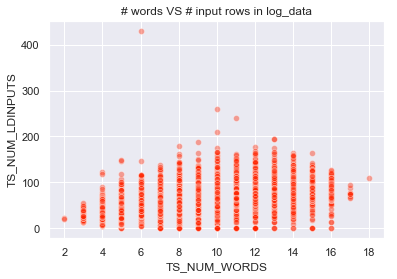

In [16]:
sns.scatterplot(x="TS_NUM_WORDS", y="TS_NUM_LDINPUTS", data = ts_data, alpha = 0.4)
plt.title('# words VS # input rows in log_data')

Text(0.5, 1.0, '# spaces VS # input rows in log_data')

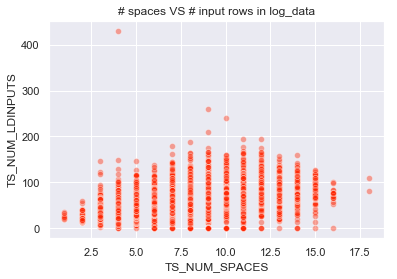

In [17]:
sns.scatterplot(x="TS_NUM_SPACES", y="TS_NUM_LDINPUTS", data = ts_data, alpha = 0.4)
plt.title('# spaces VS # input rows in log_data')

Text(0.5, 1.0, '# non-space characters VS # input rows in log_data')

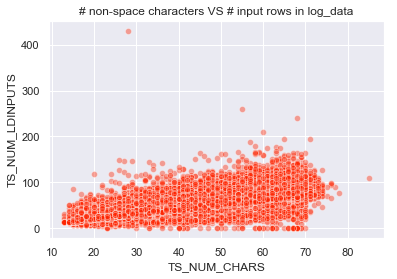

In [18]:
sns.scatterplot(x="TS_NUM_CHARS", y="TS_NUM_LDINPUTS", data = ts_data, alpha = 0.4)
plt.title('# non-space characters VS # input rows in log_data')

Text(0.5, 1.0, '# words+spaces vs # input rows in log_data')

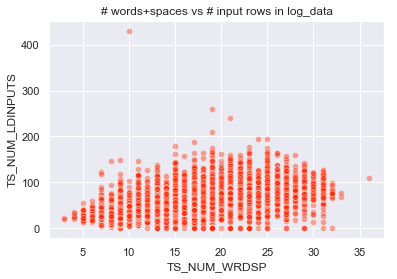

In [14]:
sns.scatterplot(x="TS_NUM_WRDSP", y="TS_NUM_LDINPUTS", data = ts_data, alpha = 0.4)
plt.title('# words+spaces VS # input rows in log_data')

Text(0.5, 1.0, '# characters+spaces VS # input rows in log_data')

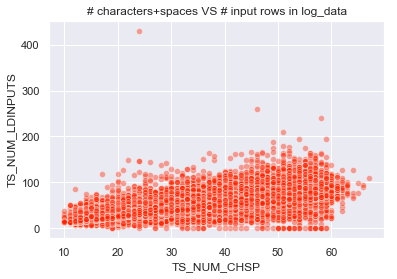

In [15]:
sns.scatterplot(x="TS_NUM_CHSP", y="TS_NUM_LDINPUTS", data = ts_data, alpha = 0.4)
plt.title('# characters+spaces VS # input rows in log_data')

## 2. Approach based on string comparison of INPUT filed

In [ ]:
# Computationally-heavy: need to compare every consecutive pair of records in LOG_DATA of type "input".
# Then, still need to develop a classification criteria (based on that comparison metric)

# If the comparison metric is "character-wise string difference", then: 

# 1. Prediction:  
# would produce numbers like 1 1 1 1 5 1 1 1 6 1 1 1 1 4 1 ... 

# 2. Autocorrection:  
# would produce numbers like 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 2 ... 

# 3. Swype:  
# would produce numbers like  1 6 1 8 1 9 1 4 1 5 ... 

## 1. Approach based on DATA associated with input events
#### Has limited validity

LD_Q = """
SELECT * FROM LOG_DATA ld
WHERE ld.TEST_SECTION_ID IN (
    SELECT ts.TEST_SECTION_ID 
    FROM TEST_SECTIONS ts 
    WHERE PARTICIPANT_ID = 131010
) AND ld.TYPE ='input'

"""

In [ ]:
TS_Q = """
SELECT * 
FROM TEST_SECTIONS 
WHERE PARTICIPANT_ID = 131010
"""

In [ ]:
# Kseniia's HTC: KEYSTROKES: NA
# ip contains  37.219.2 
# participant_id = 131010
# ts_id = [716616, 716618, 716621, 716623]
# 1) Prediction 
# 2) Autocorrection (Glissan...)
# 3) Swype (let me know...)

# Matti's Samsung: KEYSTROKES: NA
# participant_id = 134019
# ts_id = [739346, 739378, 739397]
# 1) Prediction (I'll get bisy now and...)
# 2) Autocorr (He says he saw no...)
# 3) Swype (Miller migh have to...)

# Lab iphone : Words in DATA are not in chunks, The predicted word sent as the whole. KEYSTROKES: LETTER and CODE available
# participant_id = 135310
# ts_id = (749196, 749198)
# 1) Prediction (We're on te way, The new radio mnisted was.. )
# 2) Autocorrection (They may want to...)
# 3) Swype (NA)

# Lab ipad : LOG_DATA: No key, code, or data. only INPUT available. KEYSTROKES: LETTER and CODE available
# participant_id = 135313

# 1) Prediction (Ruth I'll send this spreadsheet...)
# 2) Autocorrection (Mostly a social call, The agreement ... )
# 3) Swype (NA)

"""


select * from LOG_DATA 
where type='input' and test_section_id in (
select TEST_SECTION_ID from TEST_SECTIONS where PARTICIPANT_ID = 134019
)
"""

## Prediction: 
#### A word is split in parts (NOT ALWAYS, and "predicted" part of the word written in DATA as the whole
#### Text in INPUT grows by chunks of word
#### 
h <br>
ha <br>
ven't <- [predicted] <br>

r <br>
re <br>
ally <- [predicted] <br>


## Autocorrection: 
#### Some changes might appear in any part of the word 
#### Text in INPUT grows /changes by N letters of word (N=1,2,?)
t <br>
tr <br>
tro <br>
trom <br>
trim <- [autocorrected] <br> 


## Swype (Sometimes not applicable, depends on the kb): 
#### Full words are present in DATA column and are NOT surrounded by letters and word chunks. 
#### Text in INPUT grows by the whole word
let  <- [swype] <br>
me <- [swype] <br>
know <- [swype] <br> 

## Edit distance -based decision (0/1 decision for each feature per test section)
Compute edit distance (ED) between two consecutive words in DATA

Most-Large ED <=> likely Swype, 
Most-1 Some-Large ED <=> likely Prediction
Some-Small Some-Large ED <=> likely Autocorrection


In [ ]:
## String difference - based decision 

## LD_LDIST: Levenstein distance between two consecutive rows in (VALID_)LOG_DATA
#### Compute Levenstein distance LDIST between DATA field in 'input' rows (n) and (n-1)


In [ ]:
"""
# ALTER TABLE VALID_LOG_DATA ADD COLUMN LD_LDIST INT;

select @prev:=DATA from VALID_LOG_DATA where TYPE = 'input'
ORDER BY TEST_SECTION_ID ASC, LOG_DATA_ID ASC 
LIMIT 1,1;

update VALID_LOG_DATA ld
set ld.LD_LDIST = ( 
    select ldt.LDIST
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.DATA, 
            levenshtein(vld.DATA, @prev) as LDIST,
            @prev:=vld.DATA
        from VALID_LOG_DATA vld
        where 
            vld.TYPE = 'input' #and 
            #vld.TEST_SECTION_ID = 258053
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID #and 
        #ld.TEST_SECTION_ID = 258053
)

"""
19:31 -> 19:47 

In [ ]:
# Need to 
# 1) Filter out records with zero or one inputted character ( LOG_DATA with LENGTH(DATA) <= 1 )
# 2) Aggregate remaining LD_LDIST by test sections with some AGG function on edit distance: 
    # AVG? 
# 3) For each test section: decide on the type of intelligent method using LD_LDIST based on AGG value and mark 0|1 in correcponding column. 

# 1. 
select TYPE, INPUT, DATA, LD_LDIST from LOG_DATA
where TYPE = 'input' and LENGTH(DATA)>1

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_SW INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_AC INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_PR INT;
"""
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_INTEL_SW = (

    SELECT AVG(ld.LD_LDIST) 
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID and ld.TYPE='input' and LENGTH(ld.DATA)>0 and ld.DATA != 'null'
    
)
"""

## https://coderwall.com/p/coznrw/levenshtein-distance-using-mysql

In [ ]:

DELIMITER $$
CREATE FUNCTION levenshtein( s1 VARCHAR(255), s2 VARCHAR(255) ) 
  RETURNS INT 
  DETERMINISTIC 
  BEGIN 
    DECLARE s1_len, s2_len, i, j, c, c_temp, cost INT; 
    DECLARE s1_char CHAR; 
    -- max strlen=255 
    DECLARE cv0, cv1 VARBINARY(256); 
    SET s1_len = CHAR_LENGTH(s1), s2_len = CHAR_LENGTH(s2), cv1 = 0x00, j = 1, i = 1, c = 0; 
    IF s1 = s2 THEN 
      RETURN 0; 
    ELSEIF s1_len = 0 THEN 
      RETURN s2_len; 
    ELSEIF s2_len = 0 THEN 
      RETURN s1_len; 
    ELSE 
      WHILE j <= s2_len DO 
        SET cv1 = CONCAT(cv1, UNHEX(HEX(j))), j = j + 1; 
      END WHILE; 
      WHILE i <= s1_len DO 
        SET s1_char = SUBSTRING(s1, i, 1), c = i, cv0 = UNHEX(HEX(i)), j = 1; 
        WHILE j <= s2_len DO 
          SET c = c + 1; 
          IF s1_char = SUBSTRING(s2, j, 1) THEN  
            SET cost = 0; ELSE SET cost = 1; 
          END IF; 
          SET c_temp = CONV(HEX(SUBSTRING(cv1, j, 1)), 16, 10) + cost; 
          IF c > c_temp THEN SET c = c_temp; END IF; 
            SET c_temp = CONV(HEX(SUBSTRING(cv1, j+1, 1)), 16, 10) + 1; 
            IF c > c_temp THEN  
              SET c = c_temp;  
            END IF; 
            SET cv0 = CONCAT(cv0, UNHEX(HEX(c))), j = j + 1; 
        END WHILE; 
        SET cv1 = cv0, i = i + 1; 
      END WHILE; 
    END IF; 
    RETURN c; 
  END$$


CREATE FUNCTION levenshtein_ratio( s1 VARCHAR(255), s2 VARCHAR(255) ) 
  RETURNS INT 
  DETERMINISTIC 
  BEGIN 
    DECLARE s1_len, s2_len, max_len INT; 
    SET s1_len = LENGTH(s1), s2_len = LENGTH(s2); 
    IF s1_len > s2_len THEN  
      SET max_len = s1_len;  
    ELSE  
      SET max_len = s2_len;  
    END IF; 
    RETURN ROUND((1 - LEVENSHTEIN(s1, s2) / max_len) * 100); 
  END$$

DELIMITER ;

LD_Q = """
SELECT * FROM LOG_DATA ld
WHERE ld.TEST_SECTION_ID IN (
    SELECT ts.TEST_SECTION_ID 
    FROM TEST_SECTIONS ts 
    WHERE PARTICIPANT_ID = 131010
) AND ld.TYPE ='input'

"""

In [ ]:
TS_Q = """
SELECT * 
FROM TEST_SECTIONS 
WHERE PARTICIPANT_ID = 131010
"""

In [ ]:
# Kseniia's HTC: KEYSTROKES: NA
# ip contains  37.219.2 
# participant_id = 131010
# ts_id = [716616, 716618, 716621, 716623]
# 1) Prediction 
# 2) Autocorrection (Glissan...)
# 3) Swype (let me know...)

# Matti's Samsung: KEYSTROKES: NA
# participant_id = 134019
# ts_id = [739346, 739378, 739397]
# 1) Prediction (I'll get bisy now and...)
# 2) Autocorr (He says he saw no...)
# 3) Swype (Miller migh have to...)

# LAb iphone : Words in DATA are not in chunks, The predicted word sent as the whole. KEYSTROKES: LETTER and CODE available
# participant_id = 135310
# ts_id = (749196, 749198)
# 1) Prediction (We're on te way, The new radio mnisted was.. )
# 2) Autocorrection (They may want to...)
# 3) Swype (NA)

# LAb ipad : LOG_DATA: No key, code, or data. only INPUT available. KEYSTROKES: LETTER and CODE available
# participant_id = 135313

# 1) Prediction (Ruth I'll send this spreadsheet...)
# 2) Autocorrection (Mostly a social call, The agreement ... )
# 3) Swype (NA)

"""


select * from LOG_DATA 
where type='input' and test_section_id in (
select TEST_SECTION_ID from TEST_SECTIONS where PARTICIPANT_ID = 135310
)
"""

## Prediction: 
#### A word is split in parts (NOT ALWAYS, and "predicted" part of the word written in DATA as the whole
#### Text in INPUT grows by chunks of word
#### 
h <br>
ha <br>
ven't <- [predicted] <br>

r <br>
re <br>
ally <- [predicted] <br>


## Autocorrection: 
#### Some changes might appear in any part of the word 
#### Text in INPUT grows /changes by N letters of word (N=1,2,?)
t <br>
tr <br>
tro <br>
trom <br>
trim <- [autocorrected] <br> 


## Swype (Sometimes not applicable, depends on the kb): 
#### Full words are present in DATA column and are NOT surrounded by letters and word chunks. 
#### Text in INPUT grows by the whole word
let  <- [swype] <br>
me <- [swype] <br>
know <- [swype] <br> 

## Edit distance -based decision (0/1 decision for each feature per test section)
Compute edit distance (ED) between two consecutive words in DATA

Most-Large ED <=> likely Swype, 
Most-1 Some-Large ED <=> likely Prediction
Some-Small Some-Large ED <=> likely Autocorrection


In [ ]:
## String difference - based decision 

## LD_LDIST: Levenstein distance between two consecutive rows in (VALID_)LOG_DATA
#### Compute Levenstein distance LDIST between DATA field in 'input' rows (n) and (n-1)


In [ ]:
"""
# ALTER TABLE VALID_LOG_DATA ADD COLUMN LD_LDIST INT;

select @prev:=DATA from VALID_LOG_DATA where TYPE = 'input'
ORDER BY TEST_SECTION_ID ASC, LOG_DATA_ID ASC 
LIMIT 1,1;

update VALID_LOG_DATA ld
set ld.LD_LDIST = ( 
    select ldt.LDIST
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.DATA, 
            levenshtein(vld.DATA, @prev) as LDIST,
            @prev:=vld.DATA
        from VALID_LOG_DATA vld
        where 
            vld.TYPE = 'input' #and 
            #vld.TEST_SECTION_ID = 258053
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID #and 
        #ld.TEST_SECTION_ID = 258053
)

"""
19:31 -> 19:47 

In [ ]:
# Need to 
# 1) Filter out records with zero or one inputted character ( LOG_DATA with LENGTH(DATA) <= 1 )
# 2) Aggregate remaining LD_LDIST by test sections with some AGG function on edit distance: 
    # AVG? 
# 3) For each test section: decide on the type of intelligent method using LD_LDIST based on AGG value and mark 0|1 in correcponding column. 

# 1. 
select TYPE, INPUT, DATA, LD_LDIST from LOG_DATA
where TYPE = 'input' and LENGTH(DATA)>1

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_SW INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_AC INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_PR INT;
"""
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_INTEL_SW = (

    SELECT AVG(ld.LD_LDIST) 
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID and ld.TYPE='input' and LENGTH(ld.DATA)>0 and ld.DATA != 'null'
    
)
"""

## https://coderwall.com/p/coznrw/levenshtein-distance-using-mysql

In [ ]:

DELIMITER $$
CREATE FUNCTION levenshtein( s1 VARCHAR(255), s2 VARCHAR(255) ) 
  RETURNS INT 
  DETERMINISTIC 
  BEGIN 
    DECLARE s1_len, s2_len, i, j, c, c_temp, cost INT; 
    DECLARE s1_char CHAR; 
    -- max strlen=255 
    DECLARE cv0, cv1 VARBINARY(256); 
    SET s1_len = CHAR_LENGTH(s1), s2_len = CHAR_LENGTH(s2), cv1 = 0x00, j = 1, i = 1, c = 0; 
    IF s1 = s2 THEN 
      RETURN 0; 
    ELSEIF s1_len = 0 THEN 
      RETURN s2_len; 
    ELSEIF s2_len = 0 THEN 
      RETURN s1_len; 
    ELSE 
      WHILE j <= s2_len DO 
        SET cv1 = CONCAT(cv1, UNHEX(HEX(j))), j = j + 1; 
      END WHILE; 
      WHILE i <= s1_len DO 
        SET s1_char = SUBSTRING(s1, i, 1), c = i, cv0 = UNHEX(HEX(i)), j = 1; 
        WHILE j <= s2_len DO 
          SET c = c + 1; 
          IF s1_char = SUBSTRING(s2, j, 1) THEN  
            SET cost = 0; ELSE SET cost = 1; 
          END IF; 
          SET c_temp = CONV(HEX(SUBSTRING(cv1, j, 1)), 16, 10) + cost; 
          IF c > c_temp THEN SET c = c_temp; END IF; 
            SET c_temp = CONV(HEX(SUBSTRING(cv1, j+1, 1)), 16, 10) + 1; 
            IF c > c_temp THEN  
              SET c = c_temp;  
            END IF; 
            SET cv0 = CONCAT(cv0, UNHEX(HEX(c))), j = j + 1; 
        END WHILE; 
        SET cv1 = cv0, i = i + 1; 
      END WHILE; 
    END IF; 
    RETURN c; 
  END$$


CREATE FUNCTION levenshtein_ratio( s1 VARCHAR(255), s2 VARCHAR(255) ) 
  RETURNS INT 
  DETERMINISTIC 
  BEGIN 
    DECLARE s1_len, s2_len, max_len INT; 
    SET s1_len = LENGTH(s1), s2_len = LENGTH(s2); 
    IF s1_len > s2_len THEN  
      SET max_len = s1_len;  
    ELSE  
      SET max_len = s2_len;  
    END IF; 
    RETURN ROUND((1 - LEVENSHTEIN(s1, s2) / max_len) * 100); 
  END$$

DELIMITER ;

# Brute force computation of predictive heuristic for each record (or word) in log data

In [ ]:
# Example query to get LOG_DATA of those who indicated using swype, prediction, autocorreciton 

"""
select * from LOG_DATA 
where TEST_SECTION_ID in (
 select TEST_SECTION_ID 
 from FIRST_15_TEST_SECTIONS
 where PARTICIPANT_ID in (
 	select p.PARTICIPANT_ID 
 	from VALID_PARTICIPANTS p
 	where p.USING_FEATURES='["swipe","prediction","autocorrection"]'
 ) 
) and TYPE='input'
"""

In [ ]:
1) In data ordered by timestamp 
2) Compute difference (L distance?) between two consecutive rows
3) (Do not consider data AT and AFTER the space symbol)
4) Heuristic: 
    if LD = 1 for most of the words - normal typing 
    if LD = 1 and often jumps to 2-N (in the end of the sentence) - prediction 
    if LD >> 1 ost of the time - swype
    if LD = 1,2 (in the middle of word) - autocorr


In [ ]:
# Check for falsy inputs like ,...../////............() before running the query

# Manually removed falsy input in 
select * from LOG_DATA where LOG_DATA_ID = 32755890

"""
ALTER TABLE LOG_DATA ADD COLUMN DATA_LDIST INT;

select @prev:=DATA from LOG_DATA where TYPE = 'input'
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.DATA_LDIST = ( 
    select ldt.LDIST
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.DATA, 
            levenshtein(vld.DATA, @prev) as LDIST,
            @prev:=vld.DATA
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' 
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) 
"""
# ~ 60 min

In [ ]:
# More data to compute in SQL: 
# Length of DATA, length of prev DATA:
# DATA_LEN, DATA_PRLEN


"""
ALTER TABLE LOG_DATA ADD COLUMN DATA_LEN INT;
update LOG_DATA
set DATA_LEN = LENGTH(DATA) 
where DATA not in ('null', 'undefined', 'unidentified')
"""
# ~ 12 min

"""
ALTER TABLE LOG_DATA ADD COLUMN DATA_PRLEN INT;

select @prev:=DATA_LEN from LOG_DATA where TYPE = 'input'
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.DATA_PRLEN = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.DATA_LEN, 
            @prev:=vld.DATA_LEN 
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' and vld.DATA_LEN is not NULL
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
)
"""
# ~ 18 min

## Heuristics, formalized: 

In [ ]:
# DATA field contains information of input event:
    # InputEvent.data Read only. Returns a DOMString with the inserted characters. 
    # This may be an empty string if the change doesn't insert text (such as when deleting characters, for example)

# DATA_LDIST in a row (n) now contains edit distance between DATA fields of rows (n, n-1) (only counting TYPE= 'input')
# DATA_LEN is the length of the DATA field (only counting DATA not in ('null', 'undefined', 'unidentified'))
# DATA_PRLEN is the length of the previous DATA field (only counting DATA_LEN not null and TYPE='input')

# Intelligent text entry heuristics based on edit distance and length of word:
# row n marks "how the word was produced"

# ITE_SWYPE = 1 for row n   
# Swipe:  
#        DATA_LEN(n) > 1 and                    # Consecutive whole-words in DATA
#        DATA_LDIST(n) > 1 
      
# ITE_NORM = 1 for row n    
# Normal input:   
#        DATA_LEN(n)+1 = DATA_LEN(n+1) and      # word length increased to 1
#        DATA_LDIST(n+1) = 1                    # 1-character change in word content 
        # (same as)  DATA_LEN(n-1)+1 = DATA_LEN(n) and DATA_LDIST(n) = 1            

# ITE_NORM = 1 for row n   
# Iphone, Normal input:
#        DATA_LEN(n) = 1 and                    # input 1-by-1 character
#        DATA_LEN(n+1) = 1 and                  # input 1-by-1 character
#        DATA_LDIST(n+1) = 1                    # 1-character change in word content 
        # (same as)  DATA_LEN(n-1) = 1 and DATA_LEN(n) = 1 and DATA_LDIST(n) = 1 

# ITE_AUTOC = 1 for row n   
# Autocorrection: 
#        DATA_LEN(n) = DATA_LEN(n+1) and        # word lenght stayed the same
#        DATA_LDIST(n+1) != 0 and               # word content changed
#        DATA_LEN(n) != 1                       # except 1-letter words
        # (same as)  DATA_LEN(n-1) = DATA_LEN(n) and DATA_LDIST(n) != 0 and DATA_LEN(n) != 1  

# ITE_PREDICT = 1 for row n
# Prediciton: (when the whole predicted word is logged)
#        DATA_LDIST(n) > 2 and                     # word has changed a lot
#        DATA_LEN(n) > DATA_LDIST(n)            # length of the predicted word is more than edit distance from last entry (i.e. some chars entered, rest predicted)

# ITE_PREDICT = 1 for row n
# Prediciton: (when the only the second part of the predicted word is logged) (example: TEST_SECTION_ID 11129, 11133)
#        DATA_LDIST(n) > DATA_LEN(n) and        # Chunks are very different 
#        DATA_LEN(n-1) > 1 and                  # length of PREVIOUS word is > 1 (first chunk)
#        DATA_LEN(n) > 1                        # length of THIS word is > 1 (secind chunk)

# ITE_AUTOC = 1 for row n   
# Iphone, Autocorrection: the whole word is in DATA, DATA_LD_DIST:  
#        1 <= DATA_LEN(n) < DATA_LEN(n+1) and   # more than one character appeared in the input DATA
#        DATA_LDIST(n+1) >= 1 and               # >=1 character change in word content (it can be 1: n->on)
#        DATA_LDIST(n+1) = DATA_LEN(n)-1        # some characters of the word were entered -> last entered characted belongs to the word   
#        Number of single-characted inputs preceeding the autocorrection is (close) to length of the word
# (same as)  1 <= DATA_LEN(n-1) < DATA_LEN(n) and DATA_LDIST(n) >= 1 and DATA_LDIST(n) = DATA_LEN(n-1)-1 and ...

# Iphone, Prediction: 
#        Very similar data to Autocorretion, but fewer single-characted inputs preceeding the predicted word. 


### Errors: 
Autocorrection flags at second letter of every word



In [ ]:
# Also, get time difference between inputs should be informative! INPUT_IKI

"""
ALTER TABLE LOG_DATA ADD COLUMN INPUT_IKI INT;

select @prev:=TIMESTAMP from LOG_DATA where TYPE = 'input'
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.INPUT_IKI = ( 
    select ldt.IKI
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.TIMESTAMP, 
            vld.TIMESTAMP - @prev as IKI,
            @prev:=vld.TIMESTAMP 
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' and vld.DATA_LEN is not NULL
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) and ld.DATA_LEN is not NULL
"""


## Compute heuristics: 

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN ITE_SWYP INT;

update LOG_DATA
    set ITE_SWYP = case
        when DATA_LEN > 1 and DATA_LDIST > 1 then 1
        else ITE_SWYP
    end
where TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) and TYPE='input'


In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN ITE_AUTO INT;

update LOG_DATA
    set ITE_AUTO = case
        when (DATA_PRLEN = DATA_LEN and DATA_LDIST != 0 and DATA_LEN != 1) or (DATA_PRLEN >= 1 and DATA_PRLEN < DATA_LEN and DATA_LDIST >= 1 and DATA_LDIST = DATA_PRLEN-1) then 1
        else ITE_AUTO
    end
where TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) and TYPE='input'

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN ITE_PRED INT;

update LOG_DATA
    set ITE_PRED = case
        when (DATA_LDIST > 2 and DATA_LEN > DATA_LDIST) or (DATA_LDIST > DATA_LEN and DATA_PRLEN > 1 and DATA_LEN > 1 ) then 1
        else ITE_PRED
    end
where TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) and TYPE='input'

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN ITE_NORM INT;
update LOG_DATA
    set ITE_NORM = case
        when (DATA_PRLEN+1 = DATA_LEN and DATA_LDIST = 1) or (DATA_PRLEN = 1 and DATA_LEN = 1 and DATA_LDIST = 1 ) then 1
        else ITE_NORM
    end
where TEST_SECTION_ID in (
    select TEST_SECTION_ID
    from FIRST_15_TEST_SECTIONS
) and TYPE='input'


## Validation (on collected unlabled vs labled data)

In [ ]:
# For (unlableled) example: 
select * from LOG_DATA where TEST_SECTION_ID = 8706 and TYPE='input'

select DATA, INPUT, ITE_SWYP, ITE_AUTO, ITE_PRED, ITE_NORM, DATA_LDIST, DATA_LEN, DATA_PRLEN from LOG_DATA 
where TEST_SECTION_ID in (
 select TEST_SECTION_ID 
 from FIRST_15_TEST_SECTIONS
 where PARTICIPANT_ID in (
 	select p.PARTICIPANT_ID 
 	from VALID_PARTICIPANTS p
 	where p.USING_FEATURES='["swipe","prediction","autocorrection"]'
 ) 
) and TYPE='input' and DATA not in (' ', '.', ',', '?', '!', 'null')  and  TIMESTAMP > 1537498018000 and DATA_LDIST != 0
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC


## Analyse ITE distribution (and learn how to predict it) 

In [ ]:
# For modeling / analysis:
# 1) Filter out the rows with DATA = ' ' (space). For them, DATA_LDIST = len of the last word
# 2) Filter out the rows with DATA = null (User deletes characters) and (' ', '.', ',', '?', '!')
# 3) Sometimes there are two consecutive records with the same DATA ( ? ). Filter them out, too(DATA_LDIST = 0)
# 4) Filter out border records between test sections (i.e. first ebtry of the test section)



# Input field comparison 

In [ ]:
## Clean LOG_DATA
UPDATE LOG_DATA 
set INPUT = ''
where length(INPUT)>=100 or INPUT like '%....%' or INPUT like '%//%' or INPUT like '%\\%' or INPUT like '%||%' or INPUT like '%~~%' or INPUT like '%++%' or INPUT like '%==%' or INPUT like '%""%' or INPUT like "%''%"

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN INPUT_LDIST INT;

select @prev:=INPUT from LOG_DATA where TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.INPUT_LDIST = ( 
    select ldt.LDIST
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.INPUT, 
            levenshtein(vld.INPUT, @prev) as LDIST,
            @prev:=vld.INPUT
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN INPUT_LEN INT;
update LOG_DATA
set INPUT_LEN = LENGTH(INPUT) 

ALTER TABLE LOG_DATA ADD COLUMN INPUT_PRLEN INT;

select @prev:=INPUT_LEN from LOG_DATA where TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.INPUT_PRLEN = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.INPUT_LEN, 
            @prev:=vld.INPUT_LEN 
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN INPUT_PRLDIST INT;

select @prev:=INPUT_LDIST from LOG_DATA where TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update LOG_DATA ld
set ld.INPUT_PRLDIST = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.INPUT_LDIST, 
            @prev:=vld.INPUT_LDIST 
        from LOG_DATA vld
        where 
            vld.TYPE = 'input' and TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
)
where ld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 

In [ ]:
ALTER TABLE LOG_DATA ADD COLUMN ITE_SWYP INT;
ALTER TABLE LOG_DATA ADD COLUMN ITE_PRED INT;
ALTER TABLE LOG_DATA ADD COLUMN ITE_AUTO INT;
ALTER TABLE LOG_DATA ADD COLUMN ITE_NORM INT;

update LOG_DATA
    set ITE_SWYP = case
        when INPUT_LDIST > 2 and INPUT_PRLDIST = 0 then 1 and INPUT_LEN >= INPUT_PRLEN + 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS))     

update LOG_DATA
    set ITE_PRED = case
        when INPUT_LDIST > 1 and INPUT_PRLDIST = 1 and INPUT_LEN > INPUT_PRLEN + 1 then 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS))    

update LOG_DATA
    set ITE_AUTO = case
        when INPUT_LDIST > 1 and INPUT_PRLDIST = 1 and INPUT_LEN >= INPUT_PRLEN and INPUT_LEN <= INPUT_PRLEN + 1 then 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)) 

In [ ]:
select LOG_DATA_ID, INPUT, ITE_SWYP, ITE_PRED, ITE_AUTO from LOG_DATA where TEST_SECTION_ID in (
	select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS
	where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)
) and TYPE='input'

ORDER BY TIMESTAMP

In [ ]:
## Counting number of words per test section entered with ITE

ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_SWYP INT;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_PRED INT;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_AUTO INT;

UPDATE FIRST_15_TEST_SECTIONS ts
set N_SWYP =(
    SELECT SUM(ld.ITE_SWYP)
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
    and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)
); 

UPDATE FIRST_15_TEST_SECTIONS ts
set N_PRED =(
    SELECT SUM(ld.ITE_PRED)
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
    and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)
); 

UPDATE FIRST_15_TEST_SECTIONS ts
set N_AUTO =(
    SELECT SUM(ld.ITE_AUTO)
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
    and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS)
); 

In [ ]:
## Propotrion of words per test section entered with ITE

ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_SWYP DOUBLE;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_PRED DOUBLE;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_AUTO DOUBLE;

UPDATE FIRST_15_TEST_SECTIONS ts
set PR_SWYP =(
    N_SWYP / TS_NUM_WORDS
); 

UPDATE FIRST_15_TEST_SECTIONS ts
set PR_PRED =(
    N_PRED / TS_NUM_WORDS
); 

UPDATE FIRST_15_TEST_SECTIONS ts
set PR_AUTO =(
    N_AUTO / TS_NUM_WORDS
); 

In [ ]:
## For every participant: average use of ITE

ALTER TABLE SAMPLE_PARTICIPANTS ADD COLUMN ITE_SWYPE DOUBLE;
ALTER TABLE SAMPLE_PARTICIPANTS ADD COLUMN ITE_PREDICT DOUBLE;
ALTER TABLE SAMPLE_PARTICIPANTS ADD COLUMN ITE_AUTOCORR DOUBLE;

UPDATE SAMPLE_PARTICIPANTS p
set ITE_SWYPE =(
    SELECT AVG(ts.PR_SWYP)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 

UPDATE SAMPLE_PARTICIPANTS p
set ITE_PREDICT =(
    SELECT AVG(ts.PR_PRED)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 

UPDATE SAMPLE_PARTICIPANTS p
set ITE_AUTOCORR =(
    SELECT AVG(ts.PR_AUTO)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 